In [15]:
%matplotlib inline

## Software Comparison Project with NIDM-Results

This notebook demonstates how to reproduce the results presented in the Software Comparison Project publication using NIDM-Results packs available at [NeuroVault (2488)](https://neurovault.org/collections/2488/). We give visual comparisons between axial slices of the excursion set images and F-statistics for each software packages, as well as quantitative comparisons with Euler characteristics, Bland-Altman plots and Sørensen–Dice coefficients.

In [16]:
import os
from subprocess import check_call
import zipfile
import json
from urllib2 import urlopen, URLError, HTTPError
from urllib2 import Request
from nilearn import plotting

### Download the NIDM-Results packs from NeuroVault

 - Query NeuroVault's API to retreive all NIDM packs in collection 2488
 - Download and save the packs in sub-folder `input/ds120/` 

In [17]:
nv_collection ='2488'
study ='ds120'


request = Request('http://neurovault.org/api/collections/' + nv_collection + '/nidm_results/?limit=184&format=json')
response = urlopen(request)
elevations = response.read()
data = json.loads(elevations)

pwd = os.path.dirname(os.path.realpath('__file__'))
input_dir = os.path.join(pwd, "input")
data_dir = os.path.join(input_dir, study)

if not os.path.isdir(data_dir):
    if not os.path.isdir(input_dir):
        os.makedirs(input_dir)
    os.makedirs(data_dir)

for nidm_result in data["results"]:
    url = nidm_result["zip_file"]
    study_name = nidm_result["name"]

    localzip = os.path.join(data_dir, study_name + ".zip")
    localzip_rel = localzip.replace(pwd, '.')
    if not os.path.isfile(localzip):
        # Copy .nidm.zip export locally in a the data directory
        try:
            f = urlopen(url)
            print("downloading " + url + " at " + localzip_rel)
            with open(localzip, "wb") as local_file:
                local_file.write(f.read())
        except HTTPError, e:
            raise Exception(["HTTP Error:" + str(e.code) + url])
        except URLError, e:
            raise Exception(["URL Error:" + str(e.reason) + url])
    else:
        print(url + " already downloaded at " + localzip_rel)

for afni_image, local_name in (
        ('Positive_clustered_f_stat.nii.gz', 'afni_exc_set_pos.nii.gz'),
        ('Group_f_stat_masked.nii.gz', 'afni_stat.nii.gz'),
        ('mask.nii.gz', 'afni_mask.nii.gz')):

    url = "http://neurovault.org/media/images/" + nv_collection + '/' + afni_image
    local_file = os.path.join(data_dir, local_name)
    if not os.path.isfile(local_file):
        # Copy file locally in a the data directory
        try:
            f = urlopen(url)
            print("downloading " + url + " at " + local_file)
            with open(local_file, "wb") as local_fid:
                local_fid.write(f.read())
        except HTTPError, e:
            raise Exception(["HTTP Error:" + str(e.code) + url])
        except URLError, e:
            raise Exception(["URL Error:" + str(e.reason) + url])
    else:
        print(url + " already downloaded at " + local_file)

# for euler_char_file, local_name in (
#         ('AFNI/LEVEL2/euler_chars.csv', 'afni_euler_chars.csv'),
#         ('SPM/LEVEL2/euler_chars.csv', 'spm_euler_chars.csv')):
# 
#     url = "https://raw.githubusercontent.com/AlexBowring/Software_Comparison/master/" + study + "/" + euler_char_file
#     local_file = os.path.join(data_dir, local_name)
#     if not os.path.isfile(local_file):
#         # Copy file locally in a the data directory
#         try:
#             f = urlopen(url)
#             print("downloading " + url + " at " + local_file)
#             with open(local_file, "wb") as local_fid:
#                 local_fid.write(f.read())
#         except HTTPError, e:
#             raise Exception(["HTTP Error:" + str(e.code) + url])
#         except URLError, e:
#             raise Exception(["URL Error:" + str(e.reason) + url])
#     else:
#         print(url + " already downloaded at " + local_file)
        
for resliced_image in (('afni_spm_reslice.nii.gz', 'afni_spm_reslice_exc.nii.gz',
                        'afni_reslice_spm.nii.gz', 'afni_reslice_spm_exc.nii.gz',)):                                      
    url = "http://neurovault.org/media/images/" + nv_collection + '/' + resliced_image
    local_file = os.path.join(data_dir, resliced_image)
    if not os.path.isfile(local_file):
        # Copy file locally in a the data directory
        try:
            f = urlopen(url)
            print("downloading " + url + " at " + local_file)
            with open(local_file, "wb") as local_fid:
                local_fid.write(f.read())
        except HTTPError, e:
            raise Exception(["HTTP Error:" + str(e.code) + url])
        except URLError, e:
            raise Exception(["URL Error:" + str(e.reason) + url])
    else:
        print(url + " already downloaded at " + local_file)

https://neurovault.org/collections/2488/spm_0001.nidm.zip already downloaded at ./input/ds120/spm_0001.nidm.zip
http://neurovault.org/media/images/2488/Positive_clustered_f_stat.nii.gz already downloaded at /Users/maullz/Desktop/Software_Comparison/input/ds120/afni_exc_set_pos.nii.gz
http://neurovault.org/media/images/2488/Group_f_stat_masked.nii.gz already downloaded at /Users/maullz/Desktop/Software_Comparison/input/ds120/afni_stat.nii.gz
http://neurovault.org/media/images/2488/mask.nii.gz already downloaded at /Users/maullz/Desktop/Software_Comparison/input/ds120/afni_mask.nii.gz
http://neurovault.org/media/images/2488/afni_spm_reslice.nii.gz already downloaded at /Users/maullz/Desktop/Software_Comparison/input/ds120/afni_spm_reslice.nii.gz
http://neurovault.org/media/images/2488/afni_spm_reslice_exc.nii.gz already downloaded at /Users/maullz/Desktop/Software_Comparison/input/ds120/afni_spm_reslice_exc.nii.gz
http://neurovault.org/media/images/2488/afni_reslice_spm.nii.gz already do

In [18]:
import zipfile
import shutil
import pandas as pd

# *** SPM group activations
spm_pack = open('./input/' + study + '/spm_0001.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_pack)
z.extract('ExcursionSet.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('FStatistic.nii.gz', './input/' + study + '/')

# Thresholded statistics
spm_exc_set_file = './input/' + study + '/spm_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet.nii.gz', spm_exc_set_file)

# Unthresholded statistics
spm_stat_file = './input/' + study + '/spm_stat.nii.gz'
shutil.move('./input/' + study + '/FStatistic.nii.gz', spm_stat_file)

# Analysis mask
spm_mask_file = './input/' + study + '/spm_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', spm_mask_file)

# *** AFNI group activations and deactivations
afni_mask_file = './input/' + study + '/afni_mask.nii.gz'
afni_exc_set_file = './input/' + study + '/afni_exc_set_pos.nii.gz'
afni_stat_file = './input/' + study + '/afni_stat.nii.gz'

exc_sets = dict()
exc_sets["spm"] = (spm_mask_file, spm_exc_set_file, spm_stat_file)
exc_sets["afni"] = (afni_mask_file, afni_exc_set_file, afni_stat_file)

# *** Resliced images
# SPM resliced onto AFNI
afni_spm_reslice = './input/' + study + '/afni_spm_reslice.nii.gz'
afni_spm_reslice_pos_exc = './input/' + study + '/afni_spm_reslice_exc.nii.gz'
# AFNI resliced onto SPM
afni_reslice_spm = './input/' + study + '/afni_reslice_spm.nii.gz'
afni_reslice_spm_pos_exc = './input/' + study + '/afni_reslice_spm_exc.nii.gz'

# Euler Characteristics
# afni_euler_chars = pd.read_csv('./input/' + study + '/afni_euler_chars.csv', header=None, names=['Threshold','AFNI EC'])
# spm_euler_chars = pd.read_csv('./input/' + study + '/spm_euler_chars.csv', usecols=[1], header=None, names=['SPM EC'])
# euler_chars = pd.concat([afni_euler_chars, spm_euler_chars], axis=1)

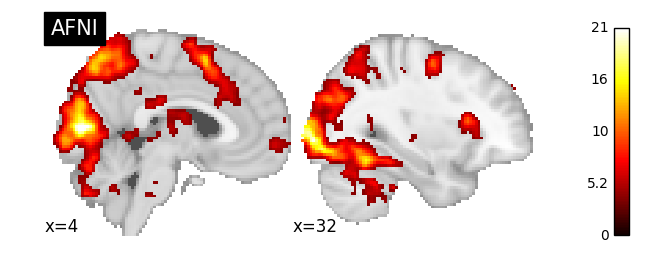

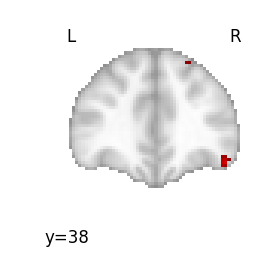

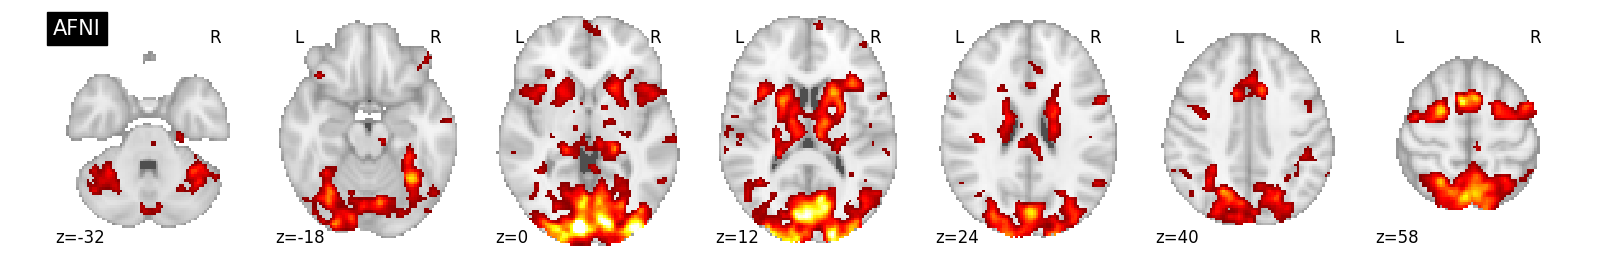

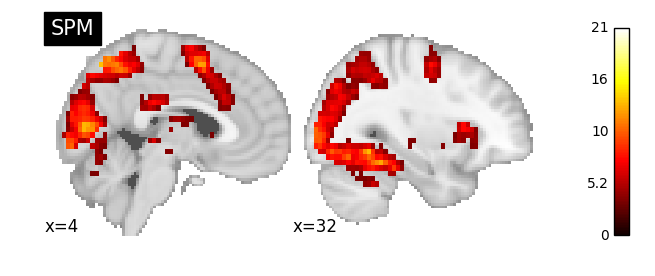

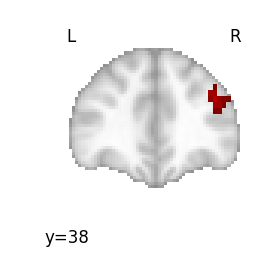

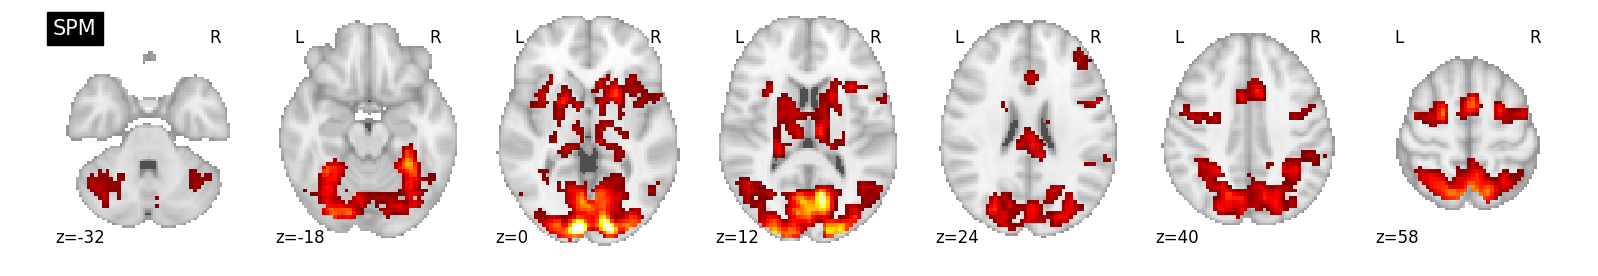

In [19]:
from scripts.lib import plot_excursion_sets
max_activation=21
reload(plot_excursion_sets)
plot_excursion_sets.plot_excursion_sets(exc_sets, max_activation)

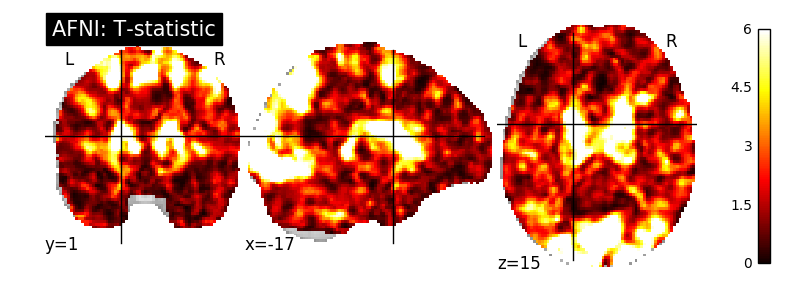

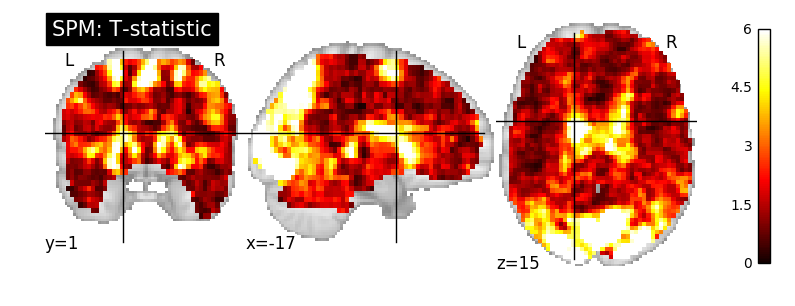

In [20]:
from scripts.lib import plot_stat_images
reload(plot_stat_images)
plot_stat_images.plot_stat_images(afni_stat_file, spm_stat_file, [-17, 1, 15])

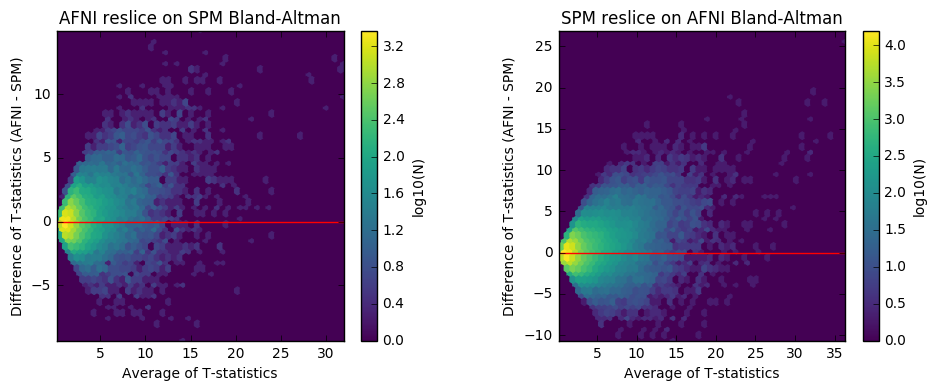

In [21]:
from scripts.lib import bland_altman
reload(bland_altman)
bland_altman.bland_altman(afni_stat_file, spm_stat_file,
             afni_reslice_spm, afni_spm_reslice)

In [22]:
from scripts.lib import dice
reload(dice)
dice.dice(afni_exc_set_file, spm_exc_set_file, 
          afni_reslice_spm_pos_exc, afni_spm_reslice_pos_exc)

AFNI/SPM positive activation dice coefficient = 0.674436761097
SPM/AFNI positive activation dice coefficient = 0.649164677804

